# SLU15 - Feature Engineering (aka Real World Data): Exercises notebook

## 1 About the data

In this exercise we will be using a synthetic financial dataset used for fraud detection, adapted from [here](https://www.kaggle.com/ntnu-testimon/paysim1).

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('data/transactions.csv')
data.head()

,time,type,risk,amount,availableBalance,nameOrig,nameDest,isFraud
0,1,TRANSFER,medium,181.00,181.0,C1305486145,C553264065,True
1,1,CASH_OUT,medium,181.00,181.0,C840083671,C38997010,True
2,1,PAYMENT,high,11668.14,41554.0,C2048537720,M1230701703,False
3,1,PAYMENT,low,4024.36,2671.0,C1265012928,M1176932104,False
4,1,PAYMENT,low,13875.98,15818.0,C484199463,M2008106788,False


The fields in this dataset have the following meaning:
* **time** - 1 hour of time in the real world. Total 744 hours (30 days simulation).
* **type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
* **risk** - low, medium, high.
* **amount** - amount of the transaction in local currency.
* **availableBalance** - initial balance before the transaction.
* **nameOrig** - customer who started the transaction.
* **nameDest** - customer who is the recipient of the transaction.
* **isFraud** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

In [3]:
X = data.copy()
y = X.pop('isFraud')

The first thing we want to do is to check the dtypes of our features.

In [4]:
X.dtypes

time                  int64
type                 object
risk                 object
amount              float64
availableBalance    float64
nameOrig             object
nameDest             object
dtype: object

## 2 Category dtype in pandas

### Exercise 1: Convert fields into category dtype (graded)

The fields `type` and `risk` are of dtype `object` but can be converted into dtype `category`, as explained in the Learning Notebook. Moreover:
* `type` is a *nominal* categorical field, that is, without any meaningful order;
* `risk` is an *ordinal* categorical field, as its values has a natural order.

In the following exercise, convert both fields into dtype `category` and, in the case of the field `risk`, assign a natural order for its categories.

In [5]:
def convert_categorical_features(X, nominal_feat='type', ordinal_feat='risk'):

    X_s = X.copy()
    
    ## convert nominal feature to dtype 'category'
    X_s= X_s.assign(type=X['type'].astype('category'))
    
    ## create list of ordered categories for ordinal feature
    ordered_cats = ['low', 'medium', 'high']
    
    ## convert ordinal feature to dtype 'category'
    X_s= X_s.assign(risk=X['risk'].astype('category'))
    
    ## Assign natural order to ordinal feature
    X_s= X_s.assign(risk=X_s['risk'].cat.set_categories(ordered_cats, ordered=True))

    # YOUR CODE HERE

    return X_s

In [6]:
"""Check that the solution is correct."""
X_cat_conv = convert_categorical_features(X)

assert X_cat_conv.type.dtype == 'category'
assert X_cat_conv.risk.dtype == 'category'
assert X_cat_conv.risk.min() == 'low'
assert X_cat_conv.risk.max() == 'high'

### Exercise 2: Encode binary target (graded)

The target variable for this dataset is `isFraud`, which was read by pandas as a field of dtype `bool`.

In [7]:
y.dtype

dtype('bool')

In this exercise, encode the target variable to be `1` when a transaction is fraudulent and `0` otherwise using the `map` method.

In [8]:
def encode_target(y):

    y_e = y.copy()
    
    ## creat a dictionary mapping the current values to int values
    mapping = {True: 1, False: 0}
    
    # enconding_map = ...
    ## change target using the mapping
    # y_e = ...
    
    #-  YOUR CODE HERE
    y_e = y_e.map(mapping)
    
    return y_e

In [9]:
"""Check that the solution is correct."""
y_encoded = encode_target(y)

assert y_encoded.dtype == 'int64'
assert y_encoded[120] == 0
assert y_encoded[58128] == 1
assert sum(y_encoded) == 8213

### Exercise 3: Discretize amount field (graded)

The field `amount` is a continuous field, with a distribution which is, not surprisingly, very skewed to the right (remember *skewness* from SLU04?).

The field 'amount' ranges from 0.0 to 60642003.0


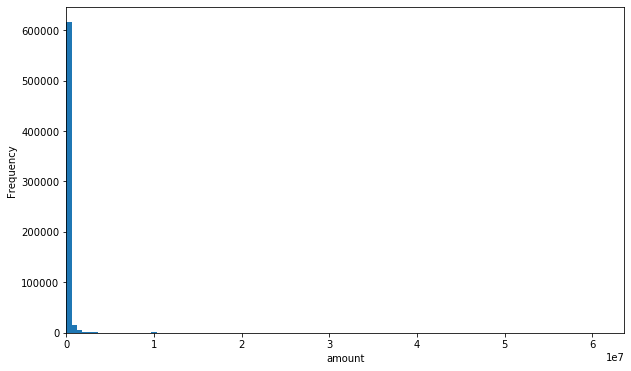

In [10]:
X.amount.plot.hist(bins=100, figsize=(10,6));
plt.xlim(0);
plt.xlabel('amount');
print("The field 'amount' ranges from", X.amount.min(), "to", X.amount.max())

In [11]:
X


,time,type,risk,amount,availableBalance,nameOrig,nameDest
0,1,TRANSFER,medium,181.00,181.00,C1305486145,C553264065
1,1,CASH_OUT,medium,181.00,181.00,C840083671,C38997010
2,1,PAYMENT,high,11668.14,41554.00,C2048537720,M1230701703
3,1,PAYMENT,low,4024.36,2671.00,C1265012928,M1176932104
4,1,PAYMENT,low,13875.98,15818.00,C484199463,M2008106788
5,1,PAYMENT,low,1614.64,41276.00,C912966811,M1792384402
6,1,PAYMENT,medium,38.66,16174.00,C343345308,M1714688478
7,1,PAYMENT,high,8586.98,3763.00,C1305004711,M494077446
8,1,CASH_OUT,low,14121.82,NaN,C69062746,C100555887
9,1,PAYMENT,high,1718.29,117811.00,C603658030,M1689924104


We will deal with the skewness in a bit. Let's first discretize this field in two ways:
* create a new field called `discrete_amount` which is the discretization of the `amount` field, such that the range is between 0 and 99 and the original instances are uniformly distributed;
* create a new field called `binary_amount` which is the binarization of the `amount` field, such that amounts smaller than `10000` become `0` and amounts equal or greater than `10000` become 1.

Use `sklearn` transformers in this exercise.

In [26]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import Binarizer

def discretize_amounts(X):

    X_a = np.array(X.amount)
    X_a = X_a.reshape(-1, 1)

    ## create new column `discrete_amount` using suitable transformer
    discretizer = KBinsDiscretizer(n_bins=100, encode='ordinal', strategy='uniform')
    discretizer.fit(X_a)
    X_a['discrete_amount'] = discretizer.transform(X_a)


    # ...
    ## create new column `binary_amount` using suitable transformer
    binarizer = Binarizer(threshold = 1000)
    binarizer.fit(X_a)
    X_a['binary_amount'] = binarizer.transform(X_a)

    # ...
    
    # YOUR CODE HERE
    X_a=pf.DataFrame(X_a)
    return X_a

In [27]:
"""Check that the solution is correct."""
X_am = discretize_amounts(X)

assert X_am.discrete_amount.nunique() == 64
assert X_am.discrete_amount.max() == 99
assert X_am.loc[322179, 'discrete_amount'] == 16
assert X_am.binary_amount.nunique() == 2
assert X_am.binary_amount.max() == 1
assert X_am.loc[322179, 'binary_amount'] == 1

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

Check the distribution of the two new fields you just calculated:

In [ ]:
X_am.discrete_amount.plot.hist(bins=100, figsize=(10,6));
plt.xlim(0,99);
plt.xlabel('discrete_amount');
plt.title('amount after discretization');

In [ ]:
X_am.binary_amount.plot.hist(figsize=(4,4));
plt.xlim(0,1);
plt.xlabel('binary_amount');
plt.title('amount after binarization');

### Exercise 4: Scale amount field (graded)

In the Learning Notebook, you also learned that numerical data can be scaled. 

In this exercise, let's scale the field `amount` in three different ways and compare the results:
* create a new field called `minmaxscaled_amount` which scales uniformly the `amount` field such that the values range from 0 to 1;
* create a new field called `standardscaled_amount` which scales the `amount` field such that the *mean* is 0 and the standard deviation is 1;
* create a new field called `robustscaled_amount` which scales the `amount` field such that the *median* is 0 and it is scaled according to the Interquartile Range.

In [22]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

def scale_amounts(X):

    X_s = X.amount
    X_s= 
    
    ## create new column `minmaxscaled_amount` using suitable transformer
    minmaxscaler = MinMaxScaler(feature_range=(0,1))
    minmaxscaler.fit(X_s)
    X['minmaxscaled_amount'] = minmaxscaler.transform(X_s)

    # ...
    ## create new column `standardscaled_amount` using suitable transformer
    standardscaler = StandardScaler()
    standardscaler.fit(X_s)
    X['standardscaled_amount'] = standardscaler.transform(X_s)

    # ...
    ## create new column `robustscaled_amount` using suitable transformer
    # ...
    robustscaler = RobustScaler()
    robustscaler.fit(X_s)
    X['robustscaled_amount'] = robustscaler.transform(X_s)
    
    return X_s

In [23]:
"""Check that the solution is correct."""
X_scaled = scale_amounts(X)

assert X_scaled.minmaxscaled_amount.min() == 0
assert X_scaled.minmaxscaled_amount.max() == 1
assert math.isclose(X_scaled.minmaxscaled_amount.mean(), 0.0032, abs_tol = 0.0001)
assert math.isclose(X_scaled.loc[12345, 'minmaxscaled_amount'], 0.00012, abs_tol = 0.00001)
assert math.isclose(X_scaled.standardscaled_amount.min(), -0.298, abs_tol = 0.001)
assert math.isclose(X_scaled.standardscaled_amount.max(), 92.75, abs_tol = 0.01)
assert math.isclose(X_scaled.standardscaled_amount.mean(), 0, abs_tol = 0.001)
assert math.isclose(X_scaled.loc[12345, 'standardscaled_amount'], -0.287, abs_tol = 0.01)
assert math.isclose(X_scaled.robustscaled_amount.min(), -0.386, abs_tol = 0.001)
assert math.isclose(X_scaled.robustscaled_amount.max(), 305.86, abs_tol = 0.01)
assert math.isclose(X_scaled.robustscaled_amount.mean(), 0.595, abs_tol = 0.002)
assert math.isclose(X_scaled.loc[12345, 'robustscaled_amount'], -0.349, abs_tol = 0.01)

ValueError: Expected 2D array, got 1D array instead:
array=[1.81000000e+02 1.81000000e+02 1.16681400e+04 ... 6.31140928e+06
 8.50002520e+05 8.50002520e+05].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

Plot the distributions for the new fields you just calculated:

In [ ]:
X_scaled.minmaxscaled_amount.plot.hist(bins=50, figsize=(10,6));
plt.xlim(0,1);
plt.xlabel('minmaxscaled_amount');
plt.title('amount after min-max scaling');

In [ ]:
X_scaled.standardscaled_amount.plot.hist(bins=50, figsize=(10,6));
plt.xlabel('standardscaled_amount');
plt.title('amount after standard scaling');

In [ ]:
X_scaled.robustscaled_amount.plot.hist(bins=50, figsize=(10,6));
plt.xlabel('robustscaled_amount');
plt.title('amount after robust scaling');

### Exercise 5: Ordinal encode risk feature

Finally, let's deal with the categorical features.

First, create a new field called `risk_encoded` which is the result of ordinal encoding of the `risk` feature.

In [ ]:
import category_encoders as ce

def encode_risk(X):
    ordinalencoder = ce.ordinal.OrdinalEncoder()

    X_r = X[['risk']]

    ordinalencoder.fit(X_r)

    # create new feature by transforming the data
    X_encoded = ordinalencoder.transform(X)
    X['risk_encoded'] = ordinalencoder.transform(X_r)

    # create new column using suitable transformer
    # YOUR CODE HERE
    
    return X_r

In [ ]:
"""Check that the solution is correct."""
X_risk = encode_risk(X)

assert X_risk.risk_encoded.dtype == int
assert X_risk.risk_encoded.min() == 1
assert X_risk.risk_encoded.max() == 3
assert X_risk.loc[12345, 'risk_encoded'] == 3

### Exercise 6: One-hot encode type feature

Finally, perform a one-hot encoding of the `type` feature. Pay attention to the following points:
* return the original DataFrame `X`, but with the `type` feature replaced by the new ones resulting from the one-hot encoding;
* make sure the new features have names of the form `type_<value>`, where `<value>` is the category being indicated by that feature.

In [ ]:
def encode_type(X):

    X_t = X[[type]]
    ohe = ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='indicator')
    ohe.fit(X_t)

    X_t['type'] = ohe.transform(X_t)
    
    return X_t

In [ ]:
"""Check that the solution is correct."""
X_type = encode_type(X)

assert X_type.shape[1] > 10
assert X_type.type_CASH_IN.sum() == 140058
assert X_type['type_-1'].sum() == 0
assert X_type.loc[12345, 'type_TRANSFER'] == 0
assert X_type.loc[362312, 'type_CASH_OUT'] == 1